In [1]:
import sys
import pandas as pd
sys.path.append('../..')

# Creature

In [2]:
from lamarck import Creature

In [3]:
genome = {
    'x': 10,
    'y': 'A',
    'z': (1, 2, 3)
}

In [4]:
creature = Creature(genome)

In [5]:
creature.id

-1163867742055844525

# Genome Creator

In [6]:
from lamarck.assistant import GenomeCreator

In [7]:
genome_creator = GenomeCreator()

In [8]:
genome_creator.add_gene_specs.numeric(name='x',
                                      min=0,
                                      max=10,
                                      progression='linear',
                                      domain='int')

genome_creator.add_gene_specs.categorical(name='y', domain=['A', 'B', 'C', 'D', 'E'])

genome_creator.add_gene_specs.vectorial(name='z', length=4, replace=False, domain=['i', 'j', 'k', 'l', 'm'])

In [9]:
genome_blueprint = genome_creator.get_genome_blueprint()

In [10]:
genome_blueprint

{'x': {'type': 'numeric',
  'domain': 'int',
  'ranges': {'min': 0, 'max': 10, 'progression': 'linear'}},
 'y': {'type': 'categorical', 'domain': ['A', 'B', 'C', 'D', 'E']},
 'z': {'type': 'vectorial',
  'domain': ['i', 'j', 'k', 'l', 'm'],
  'ranges': {'length': 4, 'replace': False}}}

# Population Creator

In [11]:
from lamarck.assistant import PopulationCreator

In [12]:
pop_creator = PopulationCreator(genome_blueprint)

In [13]:
popdet = pop_creator.create.det(8)
popdet

Population with 512 Creatures with genes x (numeric), y (categorical), z (vectorial).
        

In [14]:
popdet.datasets.input.head()

,x,y,z
id,,,
6861546195533386093,0,A,"(i, j, k, l)"
-4032542161395495972,0,A,"(i, l, k, m)"
80855953509368739,0,A,"(j, k, i, l)"
-5359771979190105310,0,A,"(j, m, k, l)"
-371711285419199414,0,A,"(k, l, i, j)"


In [15]:
poprand = pop_creator.create.rand(500)
poprand

Population with 500 Creatures with genes x (numeric), y (categorical), z (vectorial).
        

In [16]:
poprand.datasets.input.head()

,x,y,z
id,,,
-7868839330480019785,8,B,"(l, j, m, i)"
-3394323295741598217,4,E,"(j, k, l, i)"
-611500841635827503,6,B,"(k, i, l, j)"
8861049532802745730,4,B,"(l, j, k, i)"
-6098011024027929297,5,D,"(i, m, k, j)"


In [17]:
pop = popdet + poprand
pop

Population with 1012 Creatures with genes x (numeric), y (categorical), z (vectorial).
        

In [18]:
pop.drop_duplicates()
pop

Population with 783 Creatures with genes x (numeric), y (categorical), z (vectorial).
        

In [19]:
pop.datasets.input.head()

,x,y,z
id,,,
6861546195533386093,0,A,"(i, j, k, l)"
-4032542161395495972,0,A,"(i, l, k, m)"
80855953509368739,0,A,"(j, k, i, l)"
-5359771979190105310,0,A,"(j, m, k, l)"
-371711285419199414,0,A,"(k, l, i, j)"


# Environment

In [20]:
from lamarck import Environment

In [21]:
import hashlib

def tuplehash(tuple_obj):
    encoded = ''.join(tuple_obj).encode()
    m = hashlib.md5()
    m.update(encoded)
    d = m.digest()
    return int.from_bytes(d, 'big')
    
    
def dummy_process(x, y, z):
    zval = (tuplehash(z) % 1000) / (x+1)**0.75
    yval = zval // ord(y) + tuplehash((y, y)) % 73
    return {
        'time': (x + 1) * abs(zval - yval) // 10,
        'profit': (abs(3*zval - 2*yval)**((int(x/10) + 1) % 9) // (tuplehash((y, y)) % 7 + 1)) % 10000 + (zval*yval) //10
    }

In [22]:
env = Environment()

In [23]:
env.config.set_process(dummy_process)

In [24]:
env.config.set_output_varibles('time', 'profit')

In [25]:
env.config

multi:   False
output_varibles:   ('time', 'profit')
process:   <function dummy_process at 0x7f7466365700>

In [26]:
cr = pop[10]
cr

Creature <-3122765390689753995> - genome: {'x': 0, 'y': 'B', 'z': ('j', 'k', 'i', 'l')}

### Simulate Creature

In [27]:
env.simulate(cr)

{'time': 54.0, 'profit': 3384.0}

### Simulate Population

In [28]:
simpop = pop.copy()

In [29]:
env.simulate(simpop)

In [30]:
simpop.datasets.output.head()

,x,y,z,time,profit
6861546195533386093,0,A,"(i, j, k, l)",95.0,2154.0
-4032542161395495972,0,A,"(i, l, k, m)",62.0,1105.0
80855953509368739,0,A,"(j, k, i, l)",56.0,930.0
-5359771979190105310,0,A,"(j, m, k, l)",27.0,338.0
-371711285419199414,0,A,"(k, l, i, j)",45.0,715.0


### Simulate Population - Multi Thread

In [31]:
env.config.set_multi(True)

In [32]:
env.simulate(simpop)

In [33]:
simpop.datasets.output.head()

,x,y,z,time,profit
6861546195533386093,0,A,"(i, j, k, l)",95.0,2154.0
-4032542161395495972,0,A,"(i, l, k, m)",62.0,1105.0
80855953509368739,0,A,"(j, k, i, l)",56.0,930.0
-5359771979190105310,0,A,"(j, m, k, l)",27.0,338.0
-371711285419199414,0,A,"(k, l, i, j)",45.0,715.0


In [34]:
simpop.datasets.output.sort_values(['time', 'profit'])

,x,y,z,time,profit
-7732855632273756853,3,A,"(j, l, i, m)",0.0,1.0
8021172733864497183,5,C,"(m, j, k, i)",0.0,25.0
-7542270506077380496,2,C,"(k, i, l, j)",0.0,30.0
-4841892674668590186,5,C,"(j, i, l, k)",0.0,31.0
-948998627316871266,3,B,"(m, i, l, j)",0.0,60.0
...,...,...,...,...,...
674698813185448455,7,A,"(l, m, j, i)",161.0,233.0
-2867832112916964838,8,A,"(i, j, k, l)",162.0,189.0
-8207529137218438159,8,A,"(m, j, k, l)",165.0,192.0
1198081398526760981,10,A,"(i, j, k, l)",169.0,1556.0


# Fitness

### 1. Single Objective

In [35]:
single_objective_pop = simpop.copy()
single_objective_pop.apply_fitness.single_objective(output='time', objective='min')

In [36]:
single_objective_pop.datasets.fitness.head()

,x,y,z,time,profit,criteria
8021172733864497183,5,C,"(m, j, k, i)",0.0,25.0,0.0
-7542270506077380496,2,C,"(k, i, l, j)",0.0,30.0,0.0
2883727123381651283,9,B,"(i, m, j, l)",0.0,70.0,0.0
-948998627316871266,3,B,"(m, i, l, j)",0.0,60.0,0.0
3205613051495809671,7,E,"(m, l, k, i)",0.0,229.0,0.0


### 2. Multi Objective - Ranked

In [37]:
ranked_objective_pop = simpop.copy()
ranked_objective_pop.apply_fitness.multi_objective.ranked(priorities=['time', 'profit'], objectives=['min', 'max'])

In [38]:
ranked_objective_pop.datasets.fitness.head()

,x,y,z,time,profit,criteria0,criteria1
3205613051495809671,7,E,"(m, l, k, i)",0.0,229.0,0.0,229.0
-2892274780611570128,9,E,"(l, k, i, j)",0.0,228.0,0.0,228.0
-3750317927886080732,0,E,"(k, i, l, j)",0.0,182.0,0.0,182.0
2883727123381651283,9,B,"(i, m, j, l)",0.0,70.0,0.0,70.0
-2961495955366387003,9,B,"(l, j, m, i)",0.0,68.0,0.0,68.0


### 3. Multi Objective - Pareto

In [39]:
pareto_objective_pop = simpop.copy()
pareto_objective_pop.apply_fitness.multi_objective.pareto(outputs=['time', 'profit'], objectives=['min', 'max'])

In [40]:
pareto_objective_pop.datasets.fitness.head()

,x,y,z,time,profit,criteria0,criteria1,front,crowd
22643032816142471,10,E,"(i, l, k, m)",64.0,10444.0,-0.094504,6.806616,1,inf
-7732855632273756853,3,A,"(j, l, i, m)",0.0,1.0,-1.541428,-0.676658,1,inf
3205613051495809671,7,E,"(m, l, k, i)",0.0,229.0,-1.541428,-0.513277,1,inf
-3809098297114879920,10,B,"(l, m, i, j)",13.0,3417.0,-1.247521,1.771189,1,4.369722
3610556033822198082,10,B,"(l, i, k, m)",22.0,7089.0,-1.044048,4.402481,1,4.259476


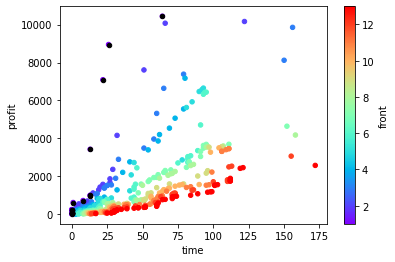

In [41]:
ax = pareto_objective_pop.plot.fronts('time', 'profit', 1)

# Selection

In [42]:
selected_pop = pareto_objective_pop.select()

In [44]:
selected_pop.datasets.fitness

,x,y,z,time,profit,criteria0,criteria1,front,crowd
22643032816142471,10,E,"(i, l, k, m)",64.0,10444.0,-0.094504,6.806616,1,inf
-7732855632273756853,3,A,"(j, l, i, m)",0.0,1.0,-1.541428,-0.676658,1,inf
3205613051495809671,7,E,"(m, l, k, i)",0.0,229.0,-1.541428,-0.513277,1,inf
-3809098297114879920,10,B,"(l, m, i, j)",13.0,3417.0,-1.247521,1.771189,1,4.369722
3610556033822198082,10,B,"(l, i, k, m)",22.0,7089.0,-1.044048,4.402481,1,4.259476
...,...,...,...,...,...,...,...,...,...
8861049532802745730,4,B,"(l, j, k, i)",99.0,1176.0,0.696782,0.165327,13,0.312179
-2743645887469063301,1,C,"(m, j, k, l)",112.0,1830.0,0.990689,0.633972,13,0.296629
1014458352483803573,3,B,"(k, l, m, j)",101.0,1507.0,0.741999,0.402515,13,0.291004
-7412042989447836145,9,E,"(j, i, l, m)",61.0,573.0,-0.162328,-0.266773,13,0.287493


# Repopulate